In [175]:
import pandas as pd 
import numpy as np
from scipy import stats
import random
import matplotlib.pyplot as plt
import seaborn as sns

class KArm(object):
    def __init__(self, true_distributions, customer_weights, classification_acc=0.9, epsilon = 0.1):
        self.epsilon = epsilon
        self.classification_acc = classification_acc
        
        self.customers = [c for c in true_distributions]
        self.customer_weights = customer_weights
        self.treatments = [t for t in true_distributions[self.customers[0]]]
        self.rewards = {name: 0 for name in self.treatments}
        self.observations = {name: 0 for name in self.treatments}
        self.true_distributions = true_distributions
        
        self.count = 0
        self.total_reward = 0
        self.average_rewards = []
        self.history = []
    
    
    def visualize_known(self):
        data = pd.DataFrame.from_dict(self.true_distributions, orient="index")
        data["customer"] = data.index
        expect = pd.melt(data, ["customer"], var_name = "treatment", value_name="true_dist")
        plt.figure(figsize=(6,4))
        ax = sns.barplot(x="treatment", y="true_dist", hue="customer", data=expect)
        ax.set_title('Probability of converting for each treatment by customer')
        ax.set_ylabel('Bernoulli Probability of Success')
        return ax
    
    
    def visualize_expectation(self, n):
        ax = sns.barplot(data=k.history[:n], x="treatment", y="conversion", ci=None)
        ax.set_title('Estimated probability of converting for each treatment')
        ax.set_ylabel('Probability of Conversion')
        return ax
    
    
    def customer_arrival(self):
        """Selects a customer to arrive based on weighted proabilities
        
        Returns:
            str: name of the selected customer
        """
        return random.choices(self.customers, weights=self.customer_weights)[0]
        
    
    def classify_customer(self, customer):
        """Classifies the known customer given an known accuracy
        
        Args:
            customer(str): the name of the known customer
        
        Returns:
            str: The name of the customer the algorithm thinks it is
        """
        if self.classification_acc > stats.uniform.rvs():
            return customer
        else:
            remaining_customers = self.customers.copy()
            remaining_customers.remove(customer)
            return random.choice(remaining_customers)
            
        
    def action_epsilon(self):
        """Selects an action to take based on epsilon greedy method
        
        Returns: 
            str: the name of the selected treatment 
        """
        if self.epsilon > stats.uniform.rvs():
            return random.choice(self.treatments)
        else:
            expectations = self.expectations()
            return random.choice(self.max_treatment(expectations))
        
            
    def reward(self, customer, treatment):
        """Returns the binary reward drawn from a known distribution 
            based on customer and action
               
        Args:
            customer (str): the customer type
            treatment (str): the treatment name
            
        Returns:
            str: the result of applying the treatment to this customer
        """
        bernoulli_prob = self.true_distributions[customer][treatment]
        return stats.bernoulli.rvs(p=bernoulli_prob)
    
    
    def customer_sim(self):
        """Simulates the arrival, classification, treatment application, 
           and reward of a single customer
           
        Modifies:
            rewards:
            observations:
            total_reward:
            count: 
            average
        """
        customer = self.customer_arrival()
        classification = self.classify_customer(customer)
        treatment = self.action_epsilon()
        reward = self.reward(classification, treatment)
        self.history.append([customer, classification, treatment, reward])
        
        self.rewards[treatment] += reward
        self.observations[treatment] += 1
        
        self.total_reward += reward
        self.count += 1
        self.average_rewards.append(self.total_reward / self.count)
    
    
    def sim_run(self, count):
        for i in range(0, count):
            self.customer_sim()
        columns = ["customer", "classification", "treatment", "conversion"]
        self.history = pd.DataFrame(self.history, columns=columns)
        
        
        
    def max_treatment(self, expectations):
        """Returns a list of the treatments with the highest expectation 
        
        Args:
            expectations (dict: [treatment]: expectation): treatments and the expected values

        Returns:
            (listof str): returns the names of all treatments that have max values
        """
        current_max = -1 # in this example, all rewards > 1
        max_treatments = []
        for t in expectations:
            if expectations[t] > current_max:
                current_max = expectations[t]
                max_treatments = [t]
            elif expectations[t] == current_max:
                max_treatments.append(t)
        return max_treatments
    
    
    def expectations(self):
        """
        Calculates the expected reward for each treatment
        """
        expectations = {}
        for t in self.treatments:
            if self.observations[t] <= 0:
                expectations[t] = 0
            else:
                expectations[t] = round(self.rewards[t] / self.observations[t], 4)
        return expectations
    
    
    def visualize_reward(self):
        plt.style.use("ggplot")
        plt.title("Expected Reward of K-Arm Bandit")
        plt.plot(range(0, len(self.average_rewards)), self.average_rewards)
        plt.ylabel("Conversion Rate")
        plt.xlabel("Number of customers")
        
        return plt.show()
    
    
    def treatment_distribution(self, n):
        return sns.countplot(data=self.history[:n], y="treatment", hue="customer")
    

### KArm Example
Let's create two customers: frequent visitors, and infrequent. They can have six treatments: No discount, 5% off, 10% off, BOGO, Coupon, Bribe. For every 10 visitors, it is expected that 9 are infrequent, 1 is frequent.

We classify the type of visitor correctly 95% of the time. 50000 visitors come to the site. We start knowing nothing

In [176]:
true_dist = {
    "frequent": {
        "No discount": 0.01,
        "5% off": 0.02,
        "10% off": 0.025,
        "BOGO": 0.2,
        "Coupon": 0.005,
        "Bribe": 0.05,
    },
    "infrequent": {
        "No discount": 0.03,
        "5% off": 0.1,
        "10% off": 0.001,
        "BOGO": 0.01,
        "Coupon": 0.08,
        "Bribe": 0.00,
    }
}
weights = [0.2, 0.8]
k = KArm(true_dist, weights)
k.sim_run(50000)

### Actual Distributions
Below are the probability that each type of customer converts for the given treatment. Clearly, we would want to offer BOGO to the frequent customer and 5% off to the 

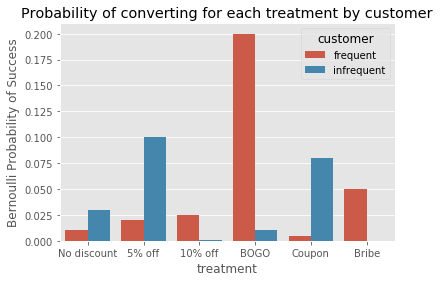

In [177]:
k.visualize_known()

### What is our expected success?

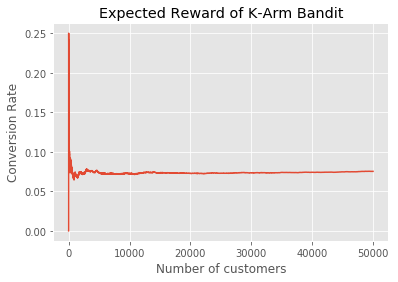

In [160]:
k.visualize_reward()

### What the algorithm learns about treatments!
A BOGO treatment attempted early with a frequent customer,

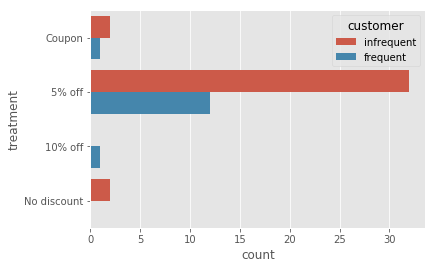

In [161]:
k.treatment_distribution(n=50)

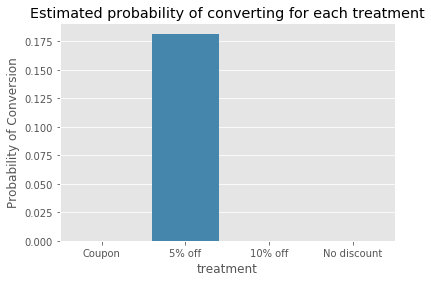

In [162]:
k.visualize_expectation(n=50)

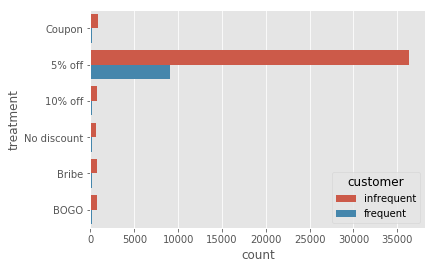

In [163]:
k.treatment_distribution(n=k.count)

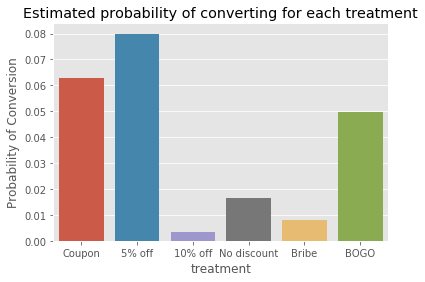

In [164]:
k.visualize_expectation(n=k.count)

In [165]:
k.history

,customer,classification,treatment,conversion
0,infrequent,infrequent,Coupon,0
1,frequent,frequent,Coupon,0
2,infrequent,infrequent,Coupon,0
3,frequent,infrequent,5% off,1
4,infrequent,infrequent,5% off,0
5,frequent,frequent,5% off,0
6,frequent,frequent,5% off,0
7,infrequent,infrequent,5% off,0
8,infrequent,infrequent,5% off,1
9,infrequent,infrequent,5% off,0
